# Final Project
### Jeff Dunagin
DSC 530

5 March 2022

# Introduction

The goal of this project will be to analyze fantasy football data. Specifically, we will look at running back data from the 2021 NFL season. The motivation is that running back is the most valuable position in fantasy football, and we want to look at what makes them successful. How are their statistics distributed? What variables are related to their success? What are the best predictors? We will explore questions of this nature as we dig into the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
players_df = pd.read_csv('data/nfl_pass_rush_receive_raw_data.csv')

In [3]:
# add a column for fantasy points
players_df['fp_PPR'] = (players_df['pass_yds']*0.04 + players_df['pass_td']*4 
                        - players_df['pass_int']*2 + players_df['rush_yds']*0.1 + 
                        players_df['rush_td']*6 + players_df['rec'] + players_df['rec_yds']*0.1
                        + players_df['rec_td']*6 - players_df['fumbles_lost']*2
                       )
# add a 'usage' column
players_df['usage'] = players_df['rush_att'] + players_df['targets']

In [4]:
# filter out only RBs
rb_df = players_df.loc[players_df['pos'] == 'RB']

In [5]:
# sum data for whole season
rb_season = rb_df.groupby(rb_df['player']).aggregate('sum')

In [6]:
# add a few more columns
rb_season['rush_yd/att'] = rb_season['rush_yds'] / rb_season['rush_att']
rb_season['rec_yd/att'] = rb_season['rec_yds'] / rb_season['rec']
rb_season['yds/usage'] = (rb_season['rush_yds'] + rb_season['rec_yds']) / rb_season['usage']
rb_season['td/usage'] = (rb_season['rush_td'] + rb_season['rec_td']) / rb_season['usage']

# Choose 5 Variables

In [7]:
# 5 variables to use
points = rb_season['fp_PPR']
yards = rb_season['rush_yds'] + rb_season['rec_yds']
tds = rb_season['rush_td'] + rb_season['rec_td']
usage = rb_season['rush_att'] + rb_season['targets']
pass_rush_diff = rb_season['targets'] - rb_season['rush_att']

The 5 variables I've chosen are total fantasy football points, total yards, touchdowns, usage, and the difference between passes thrown to and rushes attempted by a player. I'll explain these variables in detail:

Points: Total fantasy football points. Equal to a linear combination of yards, touchdowns, and receptions.

Yards: Sum of rushing and recieving yards.

Touchdowns: Sum of rushing and recieving touchdowns.

Usage: Total passes thrown to plus rushes attempted.

Pass/rush difference: Total passes thrown to  MINUS rushes attempted.

I've chosen these variables for the following reasons. Fantasy points is the most important statistic in the game: ultimately that is the metric upon which you judge a player's success. Yards and touchdowns are COMPONENTS of fantasy point, and are highly important in determining a player's success. Usage is not directly related to fantasy points, but is commonly thought of as an important predictor in a players performance. The last variable I've chosen is a way to separarate running backs in to categories based on how much they recieve vs how much they run the ball.

# Histograms and Descriptive Statistics

Here we will visualize the distributions of each variable and compute their mean, median, and standard deviations.

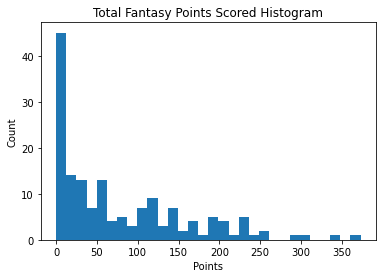

Mean: 77.9444025157233
Median: 49.8
Standard Deviation: 82.0717281820078


In [8]:
# histogram of each variable
plt.hist(points, bins = 30)
plt.title('Total Fantasy Points Scored Histogram')
plt.xlabel('Points')
plt.ylabel('Count')
plt.show()
print('Mean: {}'.format(np.mean(points)))
print('Median: {}'.format(np.median(points)))
print('Standard Deviation: {}'.format(np.std(points)))

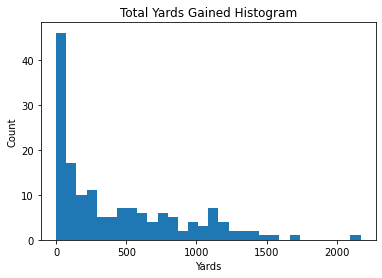

Mean: 440.17610062893084
Median: 267.0
Standard Deviation: 456.4951319198879


In [9]:
# histogram of each variable
plt.hist(yards, bins = 30)
plt.title('Total Yards Gained Histogram')
plt.xlabel('Yards')
plt.ylabel('Count')
plt.show()
print('Mean: {}'.format(np.mean(yards)))
print('Median: {}'.format(np.median(yards)))
print('Standard Deviation: {}'.format(np.std(yards)))

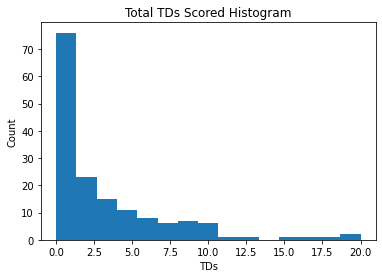

Mean: 3.0377358490566038
Median: 2.0
Standard Deviation: 4.001394084821956


In [10]:
# histogram of each variable
plt.hist(tds, bins = 15)
plt.title('Total TDs Scored Histogram')
plt.xlabel('TDs')
plt.ylabel('Count')
plt.show()
print('Mean: {}'.format(np.mean(tds)))
print('Median: {}'.format(np.median(tds)))
print('Standard Deviation: {}'.format(np.std(tds)))

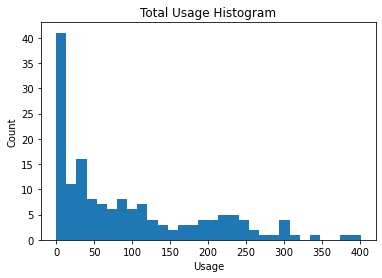

Mean: 95.43396226415095
Median: 62.0
Standard Deviation: 96.61005900346332


In [11]:
# histogram of each variable
plt.hist(usage, bins = 30)
plt.title('Total Usage Histogram')
plt.xlabel('Usage')
plt.ylabel('Count')
plt.show()
print('Mean: {}'.format(np.mean(usage)))
print('Median: {}'.format(np.median(usage)))
print('Standard Deviation: {}'.format(np.std(usage)))

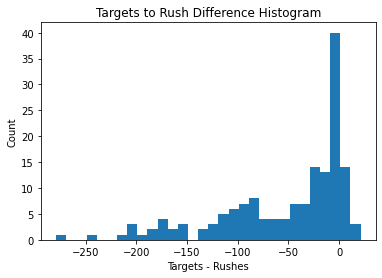

Mean: -52.84276729559748
Median: -26.0
Standard Deviation: 62.88759410021297


In [12]:
# histogram of each variable
plt.hist(pass_rush_diff, bins = 30)
plt.title('Targets to Rush Difference Histogram')
plt.xlabel('Targets - Rushes')
plt.ylabel('Count')
plt.show()
print('Mean: {}'.format(np.mean(pass_rush_diff)))
print('Median: {}'.format(np.median(pass_rush_diff)))
print('Standard Deviation: {}'.format(np.std(pass_rush_diff)))

# PMF Comparison of Two Scenarios

Here I will compare two groups of running backs: Those who tend to recieve more passes, and those who run the ball more. I will split the groups up 50-50, by finding the median and dividing it there. We will look at the distribution of fantasy points for each group.

In [55]:
# filter based on a variable
# going to filter who has more targets than rushes, and look at points

med = np.median(pass_rush_diff)
more_targets = rb_season['fp_PPR'][list(pass_rush_diff>med)]
more_rushes = rb_season['fp_PPR'][list(pass_rush_diff<=med)]

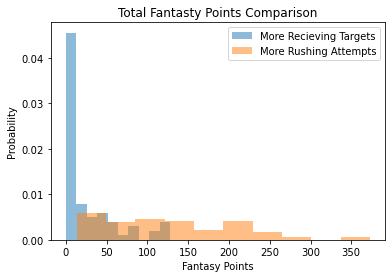

In [54]:
plt.hist(more_targets, bins=10, alpha=0.5, density=True, label='More Recieving Targets')
plt.hist(more_rushes, bins=10, alpha=0.5, density=True, label='More Rushing Attempts')
plt.legend()
plt.title('Total Fantasty Points Comparison')
plt.xlabel('Fantasy Points')
plt.ylabel('Probability')
plt.show()

Visually, we can see that the group that tends to rush more than they recieve is more successful. Running backs that are capable of recieving are often viewed as valuable, but this illustrates that you still need to have a profficient run game to be successful.

# CDF of Total Fantasy Points and Usage

We will look at the CDF of two variables: total fantasy points and usage.

In [56]:
#CDF of points
points_sorted = np.sort(np.array(points))
cdf_range = range(len(points_sorted))
cdf_range = np.array(cdf_range)
cdf_range = cdf_range/max(cdf_range)

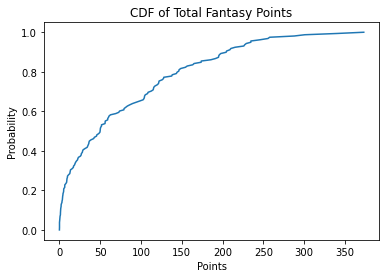

In [57]:
plt.plot(points_sorted, cdf_range)
plt.title('CDF of Total Fantasy Points')
plt.xlabel('Points')
plt.ylabel('Probability')
plt.show()

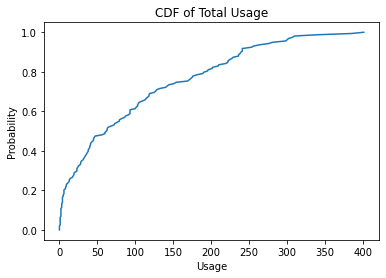

In [58]:
#CDF of usage
usage_sorted = np.sort(np.array(usage))
cdf_range = range(len(usage))
cdf_range = np.array(cdf_range)
cdf_range = cdf_range/max(cdf_range)

plt.plot(usage_sorted, cdf_range)
plt.title('CDF of Total Usage')
plt.xlabel('Usage')
plt.ylabel('Probability')
plt.show()

These two variables share something in common. Both are disproportionally skewed to having few players get most of the points, and most of the usage. Looking at the 0.5 probability mark, we have both points and usage at almost 1/6th of their maximum value. The commonly held intuition is that good running backs in the league are scarce. This is shown by the CDFs here.

This distribution seems to be similar to the pareto distribution, so we will attempt to model it off of that. We will choose to model usage, but we could just as easily model fantasy points using that as well.

# Analytical Model

The pareto distribution requires a minimum value. We will choose to set our minimum usage to 50. This will have the added benefit of not including those players who get no usage at all, and are on the whole considered irrelevant.

In [76]:
usage_sorted = np.sort(np.array(usage))
usage_sorted = usage_sorted[np.where(usage_sorted >= 50)]
cdf_range = range(len(usage_sorted))
cdf_range = np.array(cdf_range)
cdf_range = cdf_range/max(cdf_range)

In [87]:
mean_usage = np.mean(usage_sorted)
xm = 50
alpha = 1 / np.log(mean_usage/xm)

In [88]:
paretoo = stats.pareto(b=alpha, scale=xm)

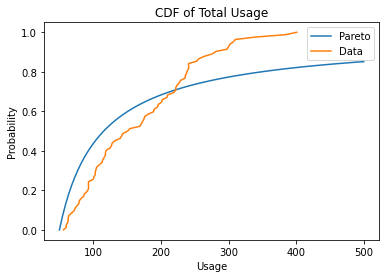

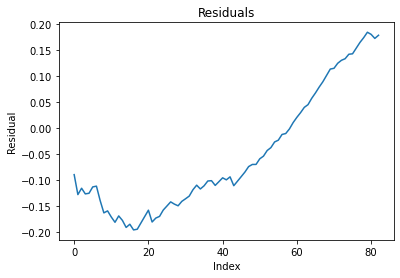

In [133]:
# plot the cdf of the pareto distribution
x = np.linspace(50,500,100)
plt.plot(x, paretoo.cdf(x), label = 'Pareto')


# plot over cdf
plt.plot(usage_sorted, cdf_range, label = 'Data')
plt.title('CDF of Total Usage')
plt.xlabel('Usage')
plt.ylabel('Probability')
plt.legend()
plt.show()

# plot residuals
plt.plot(cdf_range - paretoo.cdf(usage_sorted))
plt.title('Residuals')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()

The distribution here is not quite pareto. The residuals are not normally distributed and look to have some autocorrelation. Visually, it's a much straighter line than the pareto distribution. It's likely there is no clean distribution to which it fits.

# Scatter Plot - Correlation and Causation

We can now test the correlation between usage and points!

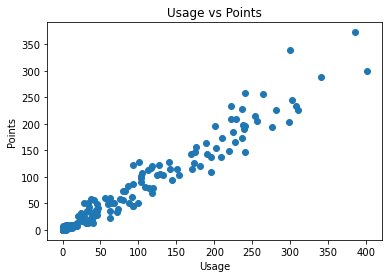

Pearson r: 0.9714841736860681
R^2: 0.9437814997225026


In [22]:
# scatter plot usage and points
plt.scatter(usage,points)
plt.title('Usage vs Points')
plt.xlabel('Usage')
plt.ylabel('Points')
plt.show()

# Relational Statistics
r = stats.pearsonr(usage,points)[0]
print('Pearson r: {}'.format(stats.pearsonr(usage,points)[0]))
print('R^2: {}'.format(r**2))

It turns out that usage and total fantasy points have a very high correlation, despite not being directly and mathematically related like other variables. This intuitively makes sense: the more you give your player opportunities, the more he will produce yards and touchdowns. This might make us think the usage causes more fantasy points, but the causation might run both ways too. If a player is producing lots of yards/touchdowns, you might be tempted to give him the ball some more. We can test that hypothesis in the next section!

# Hypothesis Test

We can test how efficiency relates to the amount of usage a player gets. We will use total fantasy points divided by usage as our measure of efficiency.

In [108]:
np.where(np.array(usage) > 20)

(array([  0,   1,   2,   4,   5,   6,   7,   9,  11,  12,  13,  14,  15,
         18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  33,  34,  35,  37,  38,  40,  41,  42,  43,  45,  46,  47,
         49,  50,  51,  52,  54,  55,  56,  57,  60,  62,  64,  65,  69,
         70,  71,  72,  73,  74,  75,  77,  79,  80,  81,  83,  85,  87,
         88,  90,  91,  92,  94,  95,  98,  99, 100, 103, 104, 105, 106,
        107, 108, 109, 110, 112, 113, 115, 116, 117, 118, 122, 123, 125,
        126, 127, 128, 130, 132, 133, 135, 136, 139, 140, 141, 143, 145,
        146, 147, 148, 152, 153, 155, 156, 158], dtype=int64),)

In [116]:
# hypothesis test
players = rb_season[rb_season['usage']>50]
use = players['rush_att'] + players['targets']
efficiency = players['fp_PPR'] / (players['rush_att'] + players['targets'])

In [119]:
# test for correlation
corr = stats.pearsonr(efficiency, use)[0]
corr

0.08104727584752795

Here we have a low positive correlation between efficiency and usage. We can plot it, then test if it is significant.

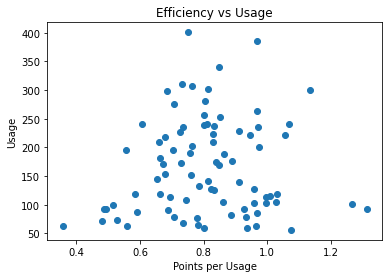

In [121]:
plt.scatter(efficiency, use)
plt.title('Efficiency vs Usage')
plt.xlabel('Points per Usage')
plt.ylabel('Usage')
plt.show()

In [123]:
# test
iters = 1000
shuffle = np.array(use)
count = 0
for _ in range(iters):
    np.random.shuffle(shuffle)
    new_corr = stats.pearsonr(shuffle, efficiency)[0]
    if new_corr > corr:
        count += 1
        
print(count/iters)
        

0.243


A p-value of 0.24 shows that this isn't significant. We can't reject the null hypothesis that efficiency and usage are unrelated.

# Regression Analysis

Here we will do a linear regression on each of the variables that contributes to the total fantasy points. The aim of this will be to compare R^2 values to find out, in practice, which variable is the best predictor for total fantasy points.

In [130]:
# Yards
reg = LinearRegression().fit(rb_season[['rush_yds', 'rec_yds']], points)
reg.score(rb_season[['rush_yds', 'rec_yds']], points)

0.9804462985321791

In [128]:
# Touchdowns
reg = LinearRegression().fit(rb_season[['rush_td', 'rec_td']], points)
reg.score(rb_season[['rush_td', 'rec_td']], points)

0.8563140484245308

In [131]:
# Receptions
reg = LinearRegression().fit(rb_season[['rec']], points)
reg.score(rb_season[['rec']], points)

0.7998986047830968

Yards has an R^2 of 0.98, while touchdowns has an R^2 of 0.85 and receptions a R^2 of 0.80. We expect these all to have high R^2 of course, because they are related by a mathematical function. However, that alone does not tell us in practice where most of the fantasy points come from. This analysis gives us the idea that yardage is the best predictor of total fantasy points. We should also note that these variables are likely correlated, but that shouldn't change our interpretation since the regression's were done separately.

# Concluding Thoughts

We dug into some data surrounding running backs in fantasy football. We looked how their points, yards, touchdowns, and usage statistics were distributed. Then, we broke the running backs into two groups to look for major differences. After that, we computed a CDF for some variables and attempted to fit it to an analytical function. Turns out, fantasy football data is messy! We attempted to find correlation with hopes of getting an insight into causation regarding usage and total points, and we found a very strong correlation. This motivated us to do a hypothesis test related to effecience of point scoring, and were not able to reject the null hypothesis. Finally, we did a regression analysis and found yards gained as the strongest explainer of fantasy points of any of the other mathematically-related variables.

This analysis was exploratory in nature. From this, we gained insight into running backs performance is distributed, and what ultimately relates to their success. Thanks for reading.